# Moisture flux divergence

The idea is to calculate horizontal moisture flux divergence, $\nabla . \vec{\mathrm{mf}}$. This can be used to calculate a moisture flux into a volume by integrating over the volume. I would be able to use this to e.g. calculate moisture flux into an MCS, or an MCS core.

$\vec{\mathrm{mf}} = \rho~q~\vec{v}$       (kg m-3 kg kg-1 m s-1 == kg m-2 s-1)

$\iint_{\mathrm{MCS}}{\nabla . \vec{\mathrm{mf}} ~dA~dz} == \oint_{\mathrm{MCS~boundary}}{\vec{\mathrm{mf}}.\vec{n}} ~dS ~dz$      (kg s-1)

The details get thorny quite quickly, and I still have lots of unresolved issues with this calc.
* How to get $\rho$? It does not seem to be available in the standard ERA5 output - perhaps calc. from geopotential height?
* How to get $dz$ taking into account orography?
* My assumptions only hold on a Cartesian grid, can I use them on a lat/lon grid?
* I need to be very careful with ERA5 data: lat decreases with increasing index, ditto z.
* Make sure I am calculating dx/dy on correct grid.
* Check working on Arakawa c-grid calcs to make sure indices all correct.
* Check area/volume weighting.

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from remake import load_remake

from mcs_prime import PATHS

In [2]:
# Load ERA5 model level data.
e5levels = pd.read_csv('/gws/nopw/j04/mcs_prime/mmuetz/data/ERA5/ERA5_L137_model_levels_table.csv')
e5levels

,n,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3]
0,0,0.000000,0.000000,0.0000,-,-,-,-,-
1,1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018
2,2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042
3,3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063
4,4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090
...,...,...,...,...,...,...,...,...,...
133,133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498
134,134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710
135,135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650
136,136,0.000000,0.997630,1010.8487,1009.5363,30.96,30.96,287.95,1.221341


In [3]:
# Really not sure how to calculate density. Use this for time being.
rho = e5levels['Density [kg/m^3]'].values[1:].astype(float)
rho

array([1.800000e-05, 4.200000e-05, 6.300000e-05, 9.000000e-05,
       1.270000e-04, 1.730000e-04, 2.330000e-04, 3.080000e-04,
       4.000000e-04, 5.120000e-04, 6.460000e-04, 8.060000e-04,
       1.007000e-03, 1.251000e-03, 1.546000e-03, 1.913000e-03,
       2.343000e-03, 2.843000e-03, 3.421000e-03, 4.084000e-03,
       4.838000e-03, 5.693000e-03, 6.655000e-03, 7.731000e-03,
       8.931000e-03, 1.026100e-02, 1.172900e-02, 1.333700e-02,
       1.501200e-02, 1.682900e-02, 1.879300e-02, 2.091000e-02,
       2.318600e-02, 2.562400e-02, 2.823200e-02, 3.101300e-02,
       3.397200e-02, 3.711500e-02, 4.044500e-02, 4.396700e-02,
       4.768500e-02, 5.160400e-02, 5.572700e-02, 6.005900e-02,
       6.460200e-02, 6.935900e-02, 7.433000e-02, 7.951600e-02,
       8.491600e-02, 9.045800e-02, 9.611000e-02, 1.019680e-01,
       1.080450e-01, 1.143550e-01, 1.209170e-01, 1.277510e-01,
       1.348770e-01, 1.423210e-01, 1.501060e-01, 1.582480e-01,
       1.667600e-01, 1.756550e-01, 1.849460e-01, 1.9464

In [4]:
# Also not sure this is the right way of calculating this.
altitude = e5levels['Geometric Altitude [m]'].values[1:].astype(float)  # in m.
dz = np.concatenate([altitude[:-1] - altitude[1:], altitude[-1:]])
dz

array([5716.74, 2666.12, 2553.02, 2459.24, 2369.1 , 2283.04, 2200.93,
       2122.68, 2048.1 , 1977.06, 1909.41, 1836.85, 1745.42, 1656.96,
       1557.29, 1461.14, 1373.62, 1293.73, 1220.64, 1153.62, 1091.99,
       1035.23,  982.83,  934.37,  889.47,  847.78,  808.7 ,  775.61,
        746.25,  718.62,  692.59,  668.03,  644.83,  622.91,  602.17,
        582.52,  563.89,  546.22,  529.43,  513.48,  498.31,  483.86,
        470.1 ,  456.93,  444.2 ,  431.85,  419.87,  408.24,  396.78,
        386.79,  377.48,  369.27,  362.09,  355.9 ,  350.58,  346.15,
        342.54,  339.53,  336.72,  333.95,  331.18,  328.46,  325.74,
        323.06,  320.39,  317.75,  315.12,  312.53,  309.95,  307.4 ,
        304.86,  302.34,  299.86,  297.38,  294.93,  292.24,  291.47,
        291.58,  291.66,  291.72,  291.77,  291.79,  291.8 ,  291.79,
        291.75,  291.69,  291.63,  291.53,  291.42,  291.29,  291.14,
        290.98,  290.79,  290.59,  290.  ,  288.32,  284.96,  280.1 ,
        274.19,  267

In [5]:
# Load some ERA5 u, v, q data.
year = 2020
month = 1
day = 11
e5datadir = PATHS['era5dir'] / f'data/oper/an_ml/{year}/{month:02d}/{day:02d}'

In [6]:
h = 6

e5time = dt.datetime(year, month, day, h, 0)
uv_paths = [e5datadir / (f'ecmwf-era5_oper_an_ml_{t.year}{t.month:02d}{t.day:02d}'
                         f'{t.hour:02d}00.{var}.nc')
            for var in ['u', 'v']
            for t in [e5time, e5time + dt.timedelta(hours=1)]]
q_paths = [e5datadir / (f'ecmwf-era5_oper_an_ml_{t.year}{t.month:02d}{t.day:02d}'
                        f'{t.hour:02d}00.q.nc')
           for t in [e5time, e5time + dt.timedelta(hours=1)]]

In [7]:
e5uv = (xr.open_mfdataset(uv_paths).sel(latitude=slice(60, -60))
        .mean(dim='time').load())
e5q = (xr.open_mfdataset(q_paths).sel(latitude=slice(60, -60))
       .mean(dim='time').load())

In [8]:
e5uv

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 481, level: 137)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... -59.5 -59.75 -60.0
  * level      (level) int32 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137
Data variables:
    u          (level, latitude, longitude) float32 80.84 80.49 ... 0.5219
    v          (level, latitude, longitude) float32 25.68 25.15 ... -1.07 -1.111

In [9]:
e5q

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 481, level: 137)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... -59.5 -59.75 -60.0
  * level      (level) int32 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137
Data variables:
    q          (level, latitude, longitude) float32 1.653e-06 ... 0.002213

In [10]:
u, v = e5uv.u.values, e5uv.v.values
q = e5q.q.values

In [11]:
q.shape

(137, 481, 1440)

In [12]:
# Check which way roll works!
np.roll(np.arange(10), -1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

In [13]:
def calc_mf_u(rho, q, u):
    """Calculates the x-component of density-weighted moisture flux on a c-grid"""
    return 1 / 4 * (q + np.roll(q, -1, axis=2)) * (u + np.roll(u, -1, axis=2)) * rho[:, None, None]

def calc_mf_v(rho, q, v):
    """Calculates the y-component of density-weighted moisture flux on a c-grid"""
    s1 = (slice(None), slice(None, -1), slice(None))
    s2 = (slice(None), slice(1, None), slice(None))
    return 1 / 4 * (q[s1] + q[s2]) * (v[s1] + v[s2]) * rho[:, None, None]

In [14]:
def calc_div_mf(rho, q, u, v, dx, dy):
    """Calculates the divergence of the moisture flux

    Switches back to original grid, but loses latitudinal extremes.
    Keeps longitudinal extremes due to biperiodic domain.
    """
    mf_u = calc_mf_u(rho, q, u)
    mf_v = calc_mf_v(rho, q, v)
    dqu_dx = (np.roll(mf_u, -1, axis=2) - mf_u) / dx[None, :, None]
    # Note, these indices are not the wrong way round!
    # latitude decreases with increasing index, hence I want the opposite
    # to what you would expect.
    dqv_dy = (mf_v[:, :-1, :]- mf_v[:, 1:, :] ) / dy
    print(mf_u.shape)
    print(mf_v.shape)
    
    return dqu_dx[:, 1:-1] + dqv_dy

In [15]:
# Calc dx/dy.
dx_deg = e5uv.longitude.values[1] - e5uv.longitude.values[0]
dy_deg = e5uv.latitude.values[0] - e5uv.latitude.values[1]  # N.B. want positive so swap indices.
Re = 6371e3  # Radius of Earth in m.

dy = dy_deg / 360 * 2 * np.pi * Re  # km
dx = np.cos(e5uv.latitude.values * np.pi / 180) * dx_deg / 360 * 2 * np.pi * Re  # km

In [16]:
div_mf = calc_div_mf(rho, q, u, v, dx, dy)

(137, 481, 1440)
(137, 480, 1440)


In [17]:
div_mf.shape

(137, 479, 1440)

In [18]:
div_mf[0, 0, 0]

-2.4158628262972e-16

In [19]:
mf_u = calc_mf_u(rho, q, u)

In [20]:
mf_v = calc_mf_v(rho, q, v)

In [21]:
# Check a hand-calc gives the same values as the fancy calc.
# Note, use dx[1] for to match mf_u[0, 1, X], and remember to reverse the order of the v calc.
np.isclose((mf_u[0, 1, 1] - mf_u[0, 1, 0]) / dx[1] + (mf_v[0, 0, 0] - mf_v[0, 1, 0]) / dy, div_mf[0, 0, 0])

True

In [22]:
np.isclose((mf_u[5, 6, 3] - mf_u[5, 6, 2]) / dx[6] + (mf_v[5, 5, 2] - mf_v[5, 6, 2]) / dy, div_mf[5, 5, 2])

True

In [23]:
# Load a mask to try masking out MCSs.
mcs_mask_time = e5time + dt.timedelta(minutes=30)
e5h = load_remake('../../remakefiles/era5_histograms.py')
# e5h
t = e5h.GenERA5Masks.tasks.filter(year=year, month=month, day=day)[0]
e5mask = xr.open_dataset(t.outputs['e5mask'])
cns = np.unique(e5mask.MCS_cloudnumber.values[6])[1:]

In [24]:
e5mask.MCS_cloudnumber.values[6].shape

(481, 1440)

In [25]:
div_mf.shape

(137, 479, 1440)

In [26]:
# Calculate areas of cells.
dx_rad = dx_deg * np.pi / 180
dy_rad = dy_deg * np.pi / 180
lats_rad = (e5uv.latitude.values * np.pi / 180)[::-1]
Acell = dx_rad * Re**2 * (np.sin(lats_rad + dy_rad / 2) - np.sin(lats_rad - dy_rad / 2))

In [27]:
# Calc. an area weighted and volume weighted div moisture flux.
Aweighted_div_mf = div_mf * Acell[None, 1:-1, None]
Vweighted_div_mf = div_mf * Acell[None, 1:-1, None] * dz[:, None, None]

vert_idx = np.ones(div_mf.shape[0]).astype('int16')

In [28]:
# Use 111 as model level at approx 800 hPa.
ml = 111

In [29]:
# %%timeit
# 4.86 s ± 96.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# This is the full (horizontal) calc.
vals1 = []
for cn in cns:
    # Use array broadcasting to multiply ones (where the current cloudnumber (cn) is true) by 
    # area weighted divergence of moisture flux.
    vals1.append((Vweighted_div_mf[ml:] * (e5mask.MCS_cloudnumber.values[6] == cn)[None, 1:-1, :]).sum())
vals1 = np.array(vals1)

In [30]:
# %%timeit
# 1.17 s ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# Faster than above, which I was a bit surprised by, dye to having to do do the same sorts of calcs
# and also a cast.
vals2 = []
for cn in cns:
    # Use array broadcasting to create mask (where the current cloudnumber (cn) is true) to select vals from 
    # area weighted divergence of moisture flux.
    m = (vert_idx[ml:, None, None] * (e5mask.MCS_cloudnumber.values[6] == cn)[None, 1:-1, :]).astype(bool)
    vals2.append(Vweighted_div_mf[ml:][m].sum())
vals2 = np.array(vals2)

28243977.58101355

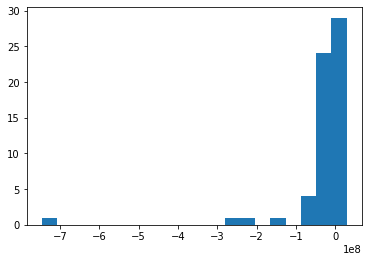

In [31]:
# Make sure `timeit` commented out above or vals not stored.
plt.hist(vals2, bins=20)
vals2.max()

Not sure why all these values are negative! I would have thought there should be substantial moisture flux into the lower levels of an MCS.

In [32]:
print(vals1[:3], vals2[:3], np.isclose(np.array(vals1), np.array(vals2)).all())
np.abs(np.array(vals1) - np.array(vals2)).max()

[-7.45233137e+08 -2.11083890e+08 -2.59223627e+08] [-7.45233137e+08 -2.11083890e+08 -2.59223627e+08] True


8.344650268554688e-07